# Binary Classification (Job Recommendation)

# Overview

In this notebook, a job remmomendation system is build using various binary classification techniques.

[Getting Started](#Getting_Started)

[Dataset](#Dataset)

[Data Distributions](#Data_Distributions)

[Encodings](#Encodings)

[Imputing](#Imputing)

[Resampling](#Resampling)

[Metrics](#Metrics)

[Modeling](#Modeling)

[Conclusion](#Conclusion)

<a name="Getting_Started"></a>

# Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [1]:
%%capture
!pip install auto-ts --upgrade
!pip install tscv


In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as random
from sklearn.model_selection import train_test_split
import xgboost as xgb
import tscv
from auto_ts import auto_timeseries

import sklearn.metrics
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = [10, 3]  # width, height
plt.rcParams['xtick.direction'] = 'out'

Imported auto_timeseries version:0.0.36. Call by using:
model = auto_timeseries(score_type='rmse',
                time_interval='M',
                non_seasonal_pdq=None, seasonality=False, seasonal_period=12,
                model_type=['best'],
                verbose=2)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



<a name="Dataset"></a>
# Dataset
Here the dataset is imported and briefly explored.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ref_directory = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(ref_directory)
print('list of files:')
print(os.listdir(ref_directory))
print('='*100)

print('Uploading the .csv file >>>>>>>>>>>>>>>>>')
dataset_path = './Stainless-Steel-Prices-Forecasty-Assignment.csv'
df = pd.read_csv(dataset_path, index_col='Date', parse_dates=True )
print('='*100)

print('Dataset info:')
print(' ')
print("dataframe shape: " , df.shape)
print(' ')
df.info()

print('='* 100)
print(' ')
print('percentage of missing values in each column:')
null_percentage = df.isnull().sum() * 100 / len(df)
print(null_percentage)

print('='* 100)
print('number of distinct values per column:')
print(' ')
print(df.nunique())
print('='*100)
df.head()

list of files:
['colab', 'Stainless-Steel-Prices-Forecasty-Assignment.csv', 'steel_price_forecasting_1.ipynb']
Uploading the .csv file >>>>>>>>>>>>>>>>>
Dataset info:
 
dataframe shape:  (84, 19)
 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2013-07-01 to 2020-06-01
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   StainlessSteelPrice       84 non-null     float64
 1   Steel_Inventory_M_USD     84 non-null     int64  
 2   Steel_Orders_M_USD        84 non-null     int64  
 3   IronOre_Global_USD        84 non-null     float64
 4   CoalAustralia_Global_USD  84 non-null     float64
 5   Energy_Index              84 non-null     float64
 6   Nickel_Global_USD         84 non-null     float64
 7   Zinc_Global_USD           84 non-null     float64
 8   Freight_Transport_Index   84 non-null     float64
 9   WTI_Crude_Global_USD      84 non-null     float64
 10  Baltic_Dry_Ind

,StainlessSteelPrice,Steel_Inventory_M_USD,Steel_Orders_M_USD,IronOre_Global_USD,CoalAustralia_Global_USD,Energy_Index,Nickel_Global_USD,Zinc_Global_USD,Freight_Transport_Index,WTI_Crude_Global_USD,Baltic_Dry_Index,BCI_China,BCI_Europe,BCI_US,CLI_China,CLI_Europe,CLI_US,PMI_US_Manufacturing,Copper_Global_USD
Date,,,,,,,,,,,,,,,,,,,
2013-07-01,0.827352,20575,10568,127.191304,82.222360,227.022942,13750.31522,1837.619565,-0.4,104.545217,1062,98.80018,99.64265,100.1044,101.1423,99.43615,100.6230,50.9,6906.64
2013-08-01,0.760221,20609,10821,137.055000,82.221429,232.234194,14308.26190,1896.392857,0.5,106.546364,1132,99.04874,99.91766,100.3962,101.1938,99.64082,100.6545,55.4,7186.25
2013-09-01,0.784715,20761,10774,134.185714,83.295918,234.335594,13801.39286,1846.880952,0.1,106.313809,2003,99.27196,100.18490,100.5363,101.2066,99.84383,100.6646,55.7,7159.27
2013-10-01,0.769293,20735,11291,132.572727,85.443634,229.393932,14117.65217,1884.836957,-0.1,100.500435,1504,99.40488,100.36330,100.5771,101.1835,100.02300,100.6666,56.2,7203.02
2013-11-01,0.750242,20854,11559,136.323810,88.363265,225.437049,13684.01190,1866.416667,2.1,93.812381,1821,99.36221,100.49830,100.5459,101.1283,100.17150,100.6744,56.4,7070.65


So the dataframe has `19` columns and none of them have any missing values.
All `18` features are numerical;

Let's plot them to see their variations.


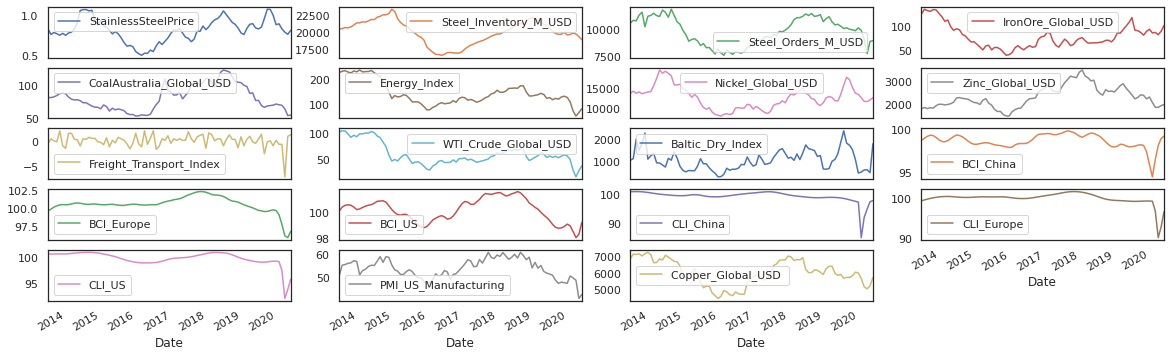

In [5]:
df.plot(figsize=(20,6), subplots=True, layout=(5,4));

In [13]:
#df['ds'] = pd.DatetimeIndex(df.index)
df = df.asfreq('MS') # Set frequency
target = 'StainlessSteelPrice' 

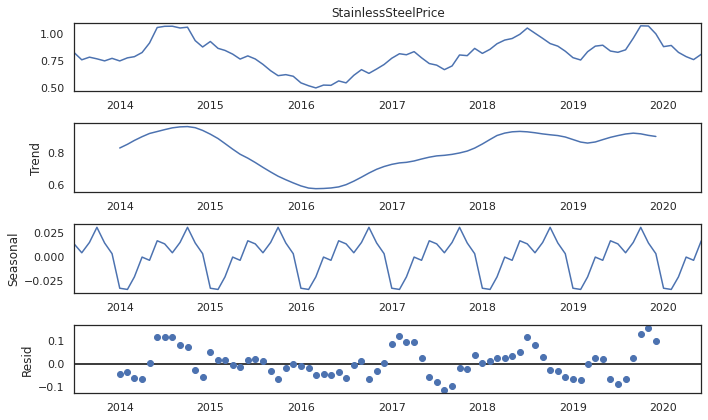

In [14]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df[target],    )
plt.rcParams["figure.figsize"] = [10, 6]  # width, height
resplot = res.plot()

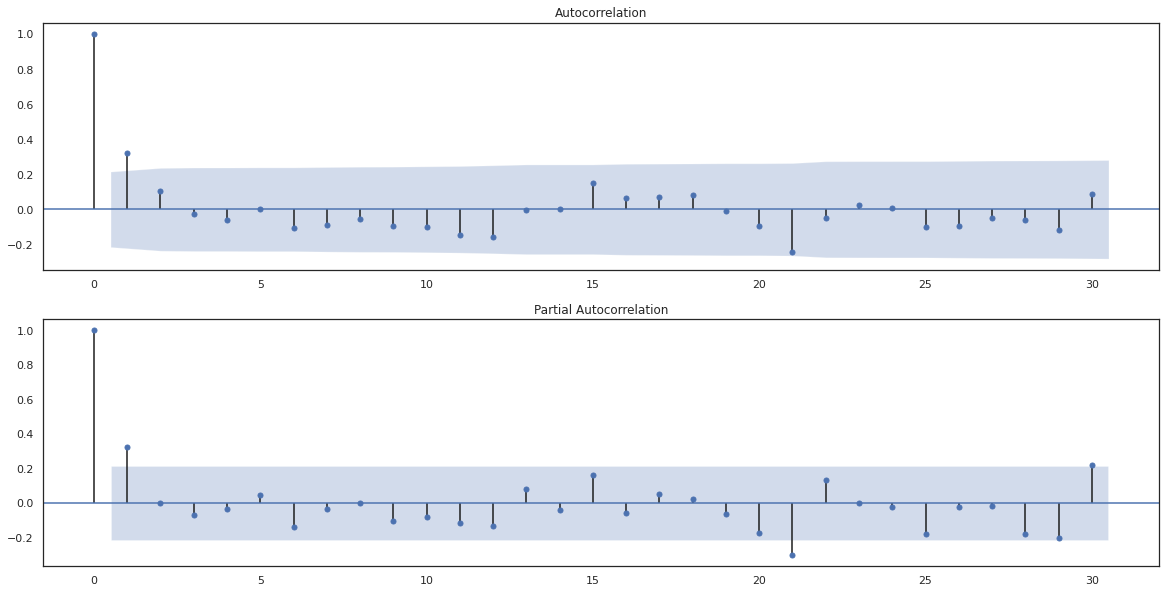

In [20]:
#we use tra.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df[target].diff().dropna(), lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df[target].diff().dropna(), lags=30, ax=ax[1])
plt.show()

In [21]:
resDiff = sm.tsa.arma_order_select_ic(df[target], max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (2, 0) is the best.


In [22]:
resDiff = sm.tsa.arma_order_select_ic(df[target].diff().dropna(), max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (1, 0) is the best.


In [23]:
arima = sm.tsa.statespace.SARIMAX(df[target],order=(1,1,0),freq='MS',seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
arima.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     StainlessSteelPrice   No. Observations:                   84
Model:                SARIMAX(1, 1, 0)   Log Likelihood                 132.060
Date:                 Wed, 28 Jul 2021   AIC                           -260.121
Time:                         16:32:47   BIC                           -255.307
Sample:                     07-01-2013   HQIC                          -258.188
                          - 06-01-2020                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3228      0.105      3.073      0.002       0.117       0.529
sigma2         0.0023      0.000      5.567      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.87   Prob(JB):                         0.73
Heteroskedasticity (H):               1.04   Skew:                             0.07
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

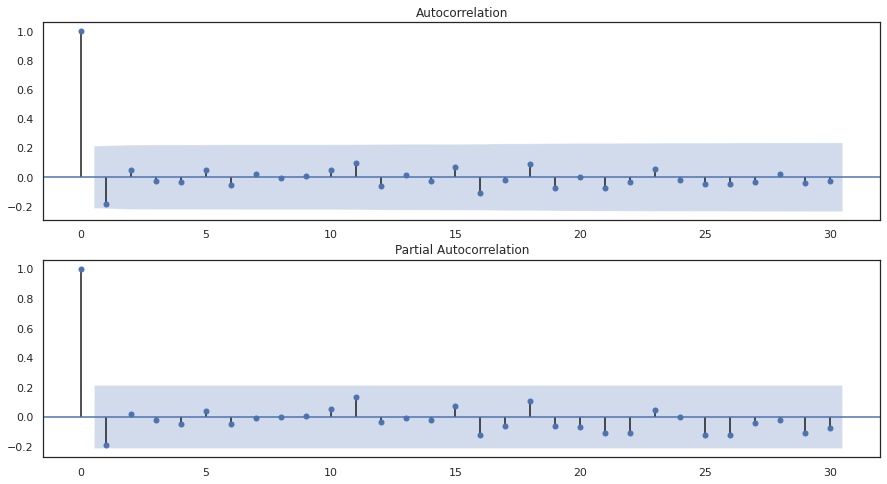

In [25]:
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [56]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    smape = np.mean( 2 * np.abs(forecast - actual)/ (actual + forecast))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape,'smape':smape, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

This model's resid have few autocorrelation.
It means that We were able to make a good model.

In [ ]:
pred = arima.predict(tr_end, te_end)[1:]
print('ARIMA model: ', forecast_accuracy(tes,pred))

In [ ]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

In [86]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def run_ExpSmoothing_cv(df,horizon, num_folds, train_lengh,damped, target, metric='smape', plot = False, seasonality= False):
    cv_metrics = []
    for i in range(1, num_folds+1):
        train_df , test_df = train_test_df(df, train_len = train_lengh, horizon = horizon, fold = num_folds, fold_i = i)
        model = ExponentialSmoothing(train_df[target].values, trend="add", damped=damped)
        if seasonality:
            model = ExponentialSmoothing(train_df[target].values, trend="add", seasonal="add", seasonal_periods=12, damped=damped)
        fit = model.fit()
        pred = fit.forecast(horizon)
        metrics = forecast_accuracy(pred, test_df[target])
        train_test = pd.concat([train_df[target] , test_df[target]], axis=0)
        #print('fold ' + str(i))
        #print(metrics)
        cv_metrics.append(metrics[metric])
        if plot:
            fig, ax = plt.subplots(figsize=(10, 3))
            ax.plot(train_test.index, train_test.values, label='truth');
            ax.plot(test_df.index, pred, linestyle='--', color='#ff7823', label= metric + " ={:0.2f})".format(metrics[metric]));
            ax.legend();
            ax.set_title("Holt-Winter's Seasonal Smoothing");
    print('average cross validated '+ metric + ' is >>>>>>>>>>>>>>>>>>>>>>>>>>>> ' )
    return np.mean(cv_metrics)

In [91]:
run_ExpSmoothing_cv(df,horizon=3, num_folds=15, train_lengh=24, damped=True, target=target, metric='smape', plot = False, seasonality = True)

average cross validated smape is >>>>>>>>>>>>>>>>>>>>>>>>>>>> 


0.13034339524490568

In [92]:
run_ExpSmoothing_cv(df,horizon=3, num_folds=15, train_lengh=24, damped=True, target=target, metric='smape', plot = False, seasonality = False)

average cross validated smape is >>>>>>>>>>>>>>>>>>>>>>>>>>>> 


0.0610451373987715

In [94]:
# Converting the index as date
df_fb = df.copy().reset_index().rename({'Date':'ds','StainlessSteelPrice':'y'}, axis=1)
df_fb.head(1)

,ds,y,Steel_Inventory_M_USD,Steel_Orders_M_USD,IronOre_Global_USD,CoalAustralia_Global_USD,Energy_Index,Nickel_Global_USD,Zinc_Global_USD,Freight_Transport_Index,WTI_Crude_Global_USD,Baltic_Dry_Index,BCI_China,BCI_Europe,BCI_US,CLI_China,CLI_Europe,CLI_US,PMI_US_Manufacturing,Copper_Global_USD
0,2013-07-01,0.827352,20575,10568,127.191304,82.22236,227.022942,13750.31522,1837.619565,-0.4,104.545217,1062,98.80018,99.64265,100.1044,101.1423,99.43615,100.623,50.9,6906.64


In [95]:
#test_length = 20
split_date = "2020-01-01"
train_filt = df_fb['ds'] <= split_date
test_filt = df_fb['ds'] > split_date

train_fb = df_fb[train_filt]
test_fb = df_fb[test_filt]

print("train data shape :", train_fb.shape[0] / df_fb.shape[0] * 100)
print("test data shape :", test_fb.shape[0] / df_fb.shape[0] * 100)

train data shape : 94.04761904761905
test data shape : 5.952380952380952


In [96]:
#train_fb = train_fb.reset_index()
#test_fb = test_fb.reset_index()
#test_fb.head()

In [97]:
automl_model = auto_timeseries(score_type='rmse', 
                time_interval='MS', forecast_period=3,
                non_seasonal_pdq=None, seasonality=False, seasonal_period=12,
                model_type=['best'],
                verbose=2)

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |      -1.323679770995752      |
|           p-value           |      0.6182703721847378      |
|          #Lags Used         |             0.0              |
| Number of Observations Used |             66.0             |
|     Critical Value (1%)     |     -3.5335601309235605      |
|     Critical Value (5%)     |     -2.9064436883991434      |
|     Critical Value (10%)    |      -2.590723948576676      |
+-----------------------------+------------------------------+
 this series is non-stationary. Trying test again after differencing...
After differencing=1, results of Augmented Dickey-Fuller Test:
+-----------------

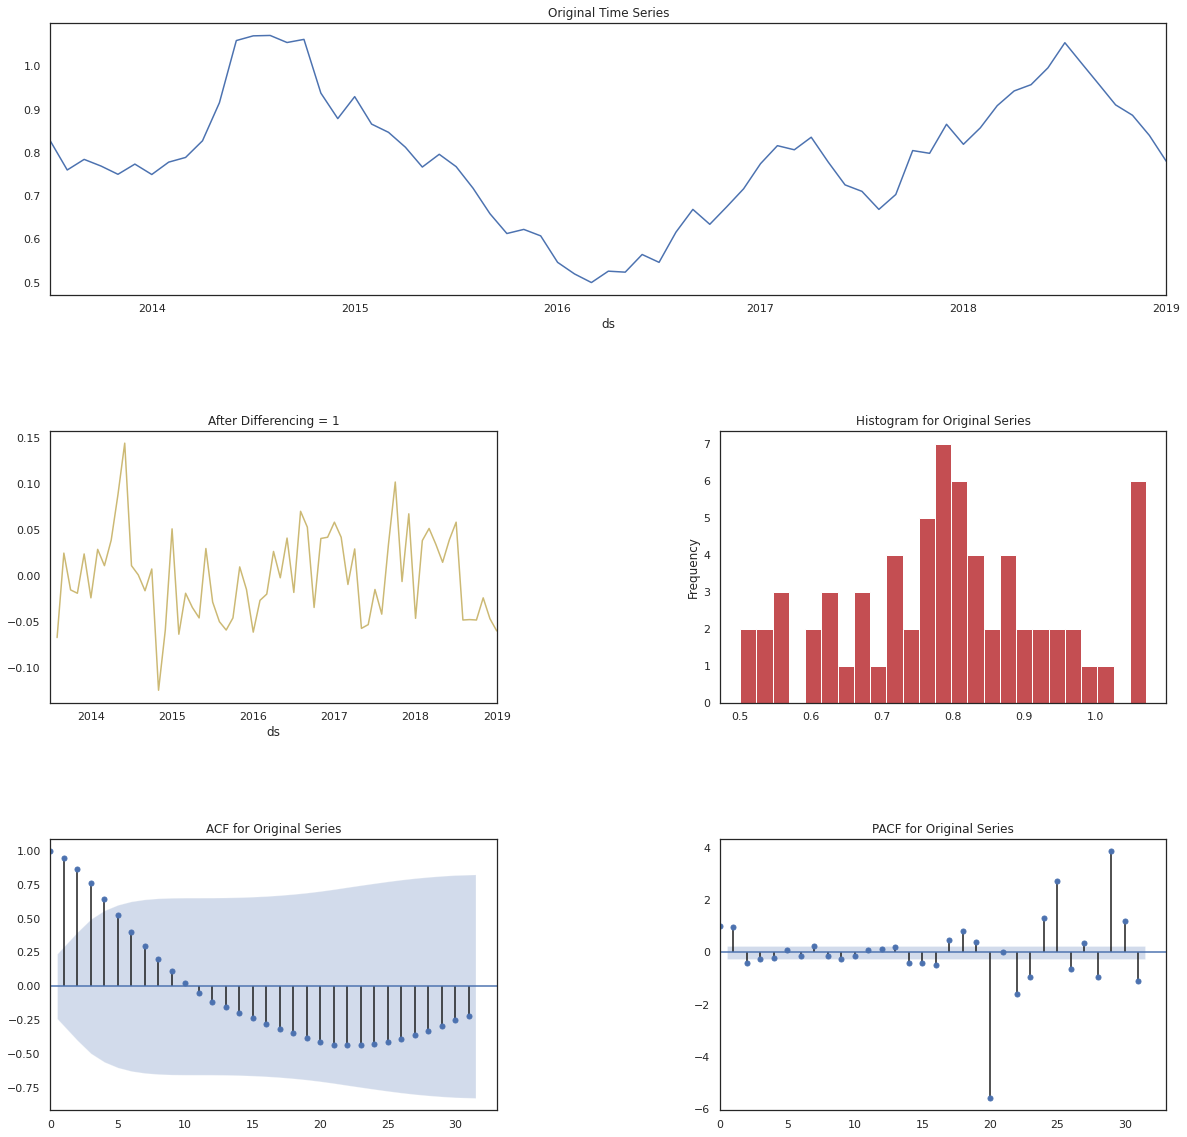

Time Interval is given as MS
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
    Fit-Predict data (shape=(67, 20)) with Confidence Interval = 0.95...
  Starting Prophet Fit
       Adding monthly seasonality to Prophet with period=12, fourier_order=12 and prior_scale=0.10
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 42 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 0.27
    Std Deviation of actuals = 0.02
    Normalized RMSE = 1186%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 47 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 0.10
    Std Deviation of actuals = 0.05
    Normalized RMSE = 218%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 52 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 0.23
    Std Deviation o

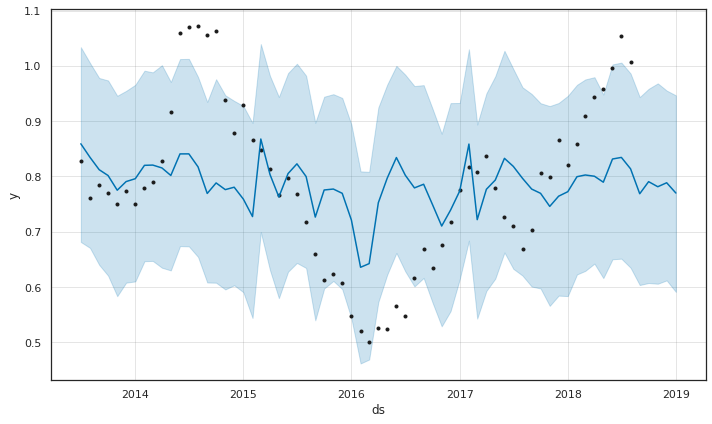

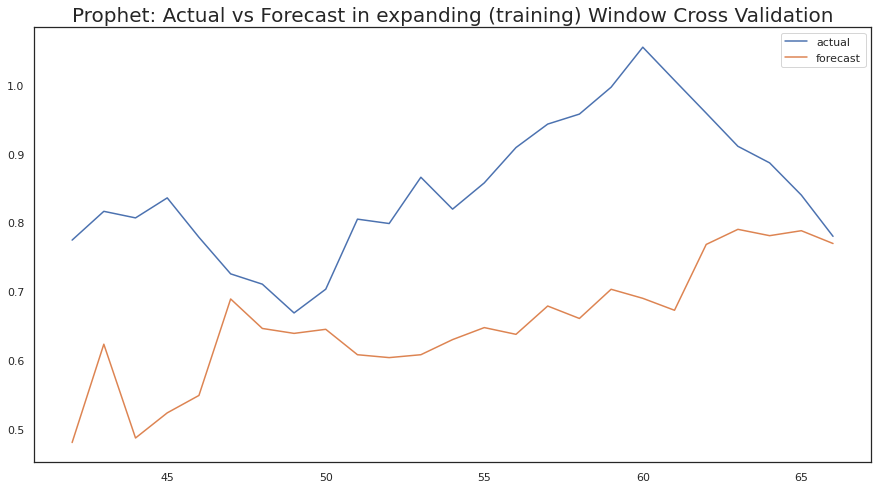

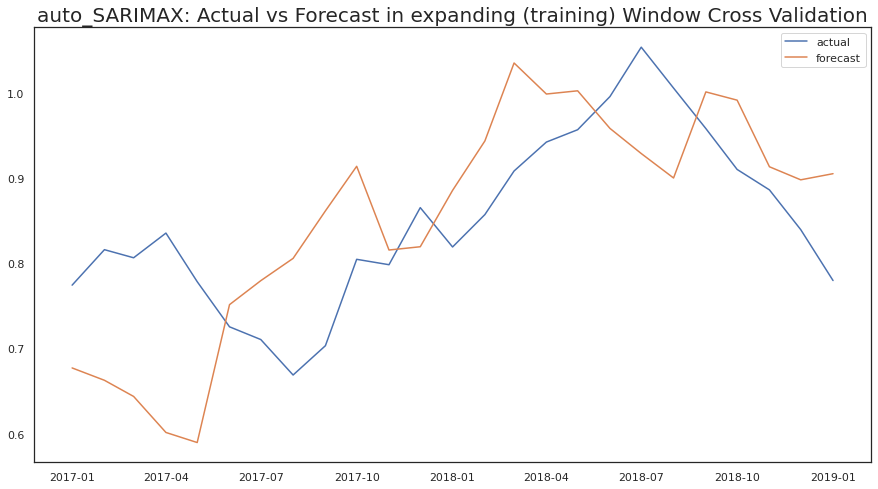

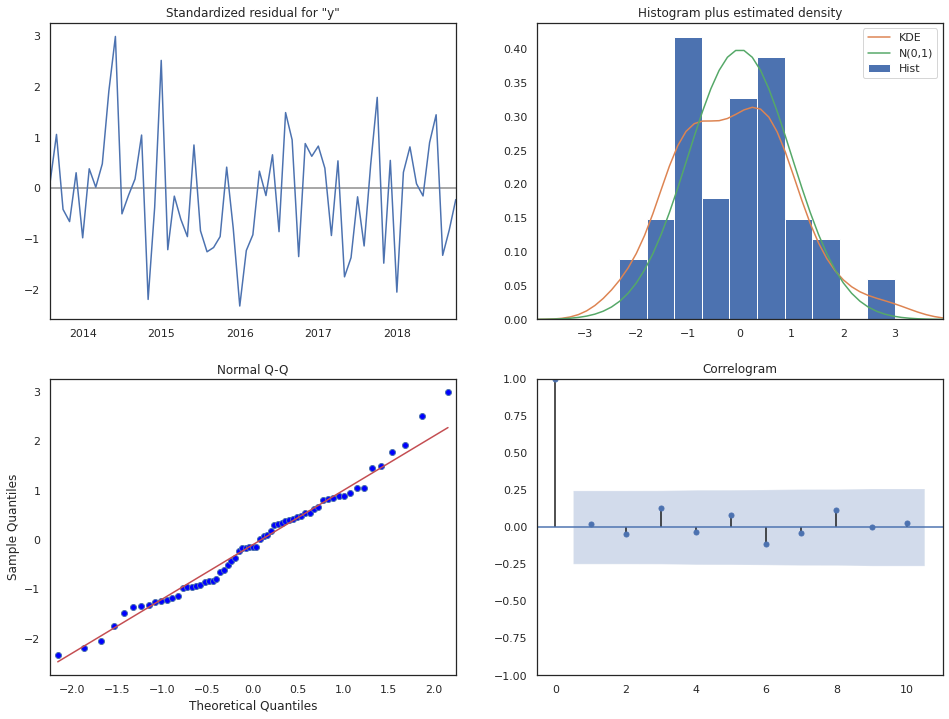

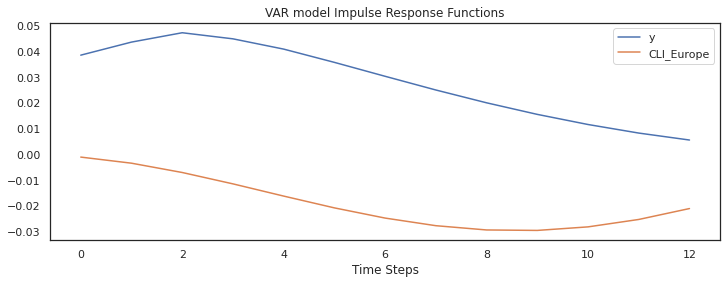

In [29]:
ts_column = 'ds'
target = 'y'
automl_model.fit(
    traindata=train_fb,
    ts_column=ts_column,
    target=target,
    cv=10,
    sep=',')

In [30]:
#model = auto_timeseries(score_type='rmse', time_interval='MS', seasonality=True, model_type=[ 'stats',  'ML'], verbose=2)
automl_model.get_leaderboard()


,name,rmse
2,VAR,0.075897
1,auto_SARIMAX,0.103931
0,Prophet,0.205067
3,ML,inf


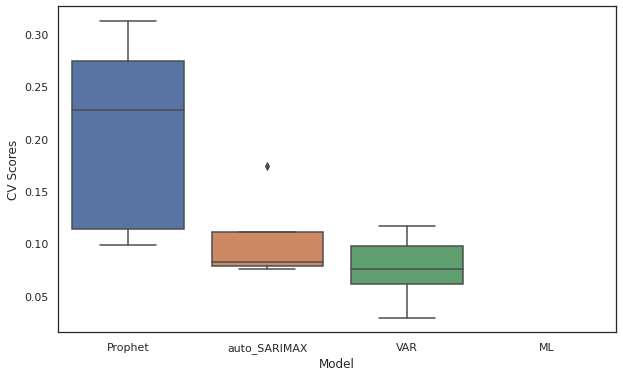

In [31]:
automl_model.plot_cv_scores()

In [32]:
results_dict = automl_model.get_ml_dict()
results_dict['Prophet']['forecast'][:5]
# results_dict['auto_SARIMAX']['forecast'][:5]

array([0.48103781, 0.62369265, 0.48762668, 0.52407778, 0.5493571 ])

In [49]:
future_predictions = automl_model.predict(
    testdata=test_fb
)
future_predictions.head()

y,yhat,mean_se,mean_ci_lower,mean_ci_upper
2019-02-01,0.743207,0.037675,0.669366,0.817049
2019-03-01,0.709100,0.057033,0.597317,0.820883
2019-04-01,0.682110,0.073547,0.537960,0.826261
2019-05-01,0.660525,0.085924,0.492116,0.828933
2019-06-01,0.644809,0.095021,0.458570,0.831047


In [50]:
# Using specific model
future_predictions = automl_model.predict(
    testdata=test_fb,
    model='auto_SARIMAX'
)

Building Forecast dataframe. Forecast Period = 17


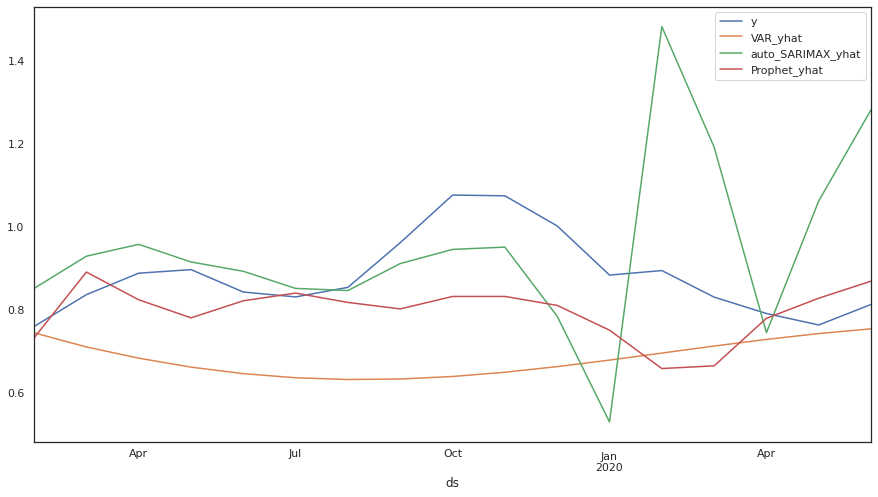

In [45]:
subm = test_fb[['ds',target]].copy()
for model in ['VAR', 'auto_SARIMAX' , 'Prophet']:
    future_predictions = automl_model.predict(
        testdata=test_fb,
        model=model
    )
    subm[model+'_yhat'] = future_predictions['yhat'].values

subm.set_index('ds', inplace=True)
subm.plot(figsize=(15,8))

Start of Fit.....
    Target variable given as = y
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_column: ds sep: , target: y
    Loaded pandas dataframe...
    pandas Dataframe loaded successfully. Shape of data set = (84, 19)
No time series plot since verbose = 0. Continuing
Time Interval is given as MS
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
  Starting Prophet Fit
       Adding monthly seasonality to Prophet with period=12, fourier_order=12 and prior_scale=0.10
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 59 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 0.28
    Std Deviation of actuals = 0.05
    Normalized RMSE = 574%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 64 Test Shape: 5
    Root Mean Squared Error predictions vs

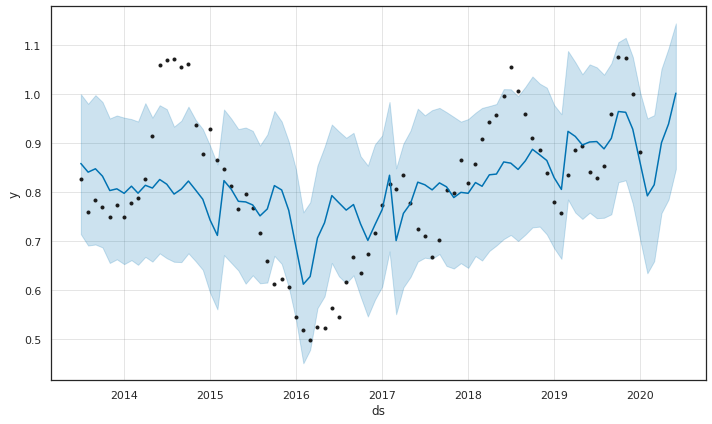

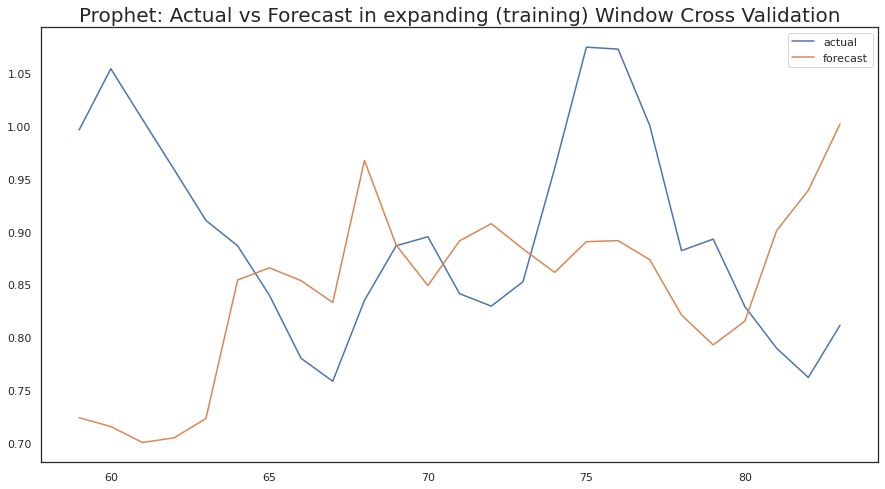

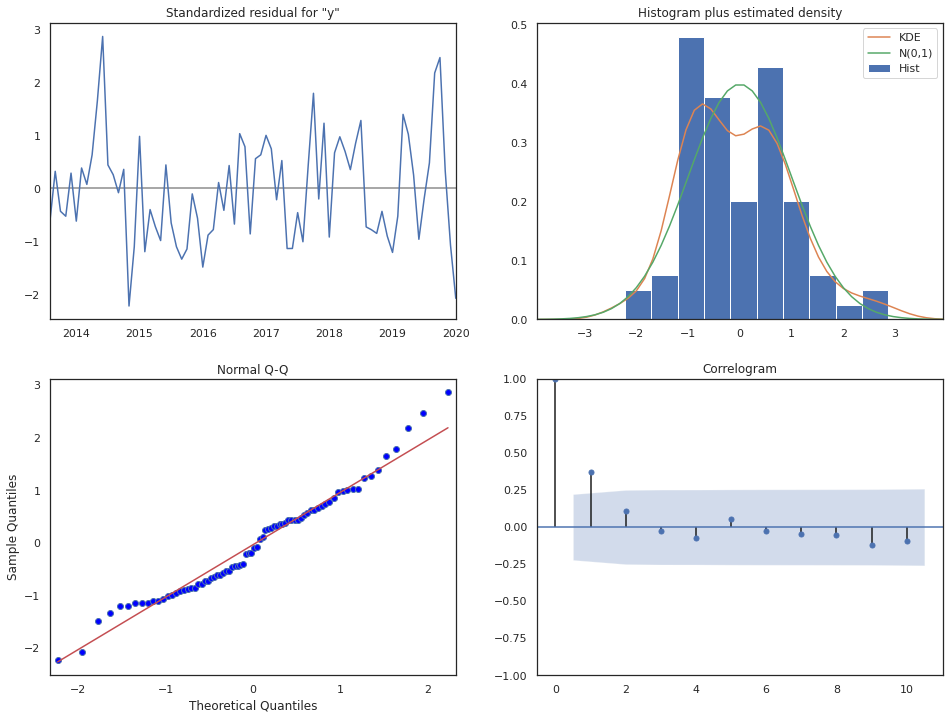

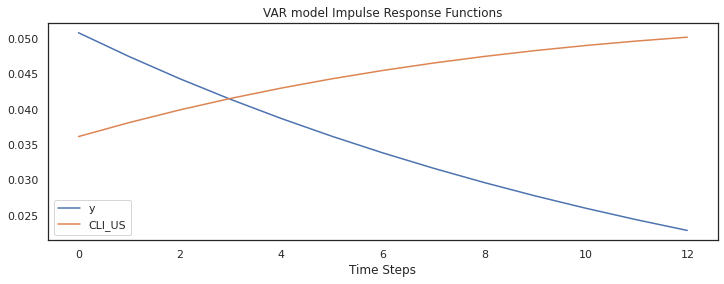

In [62]:
automl_model = auto_timeseries(score_type='rmse', 
                time_interval='MS', forecast_period=5,
                non_seasonal_pdq=(1,0,0), seasonality=True, seasonal_period=12,
                model_type=['best'],
                verbose=0)

automl_model.fit(
    traindata=df_fb,
    ts_column=ts_column,
    target=target,
    cv=5,
    sep=',')

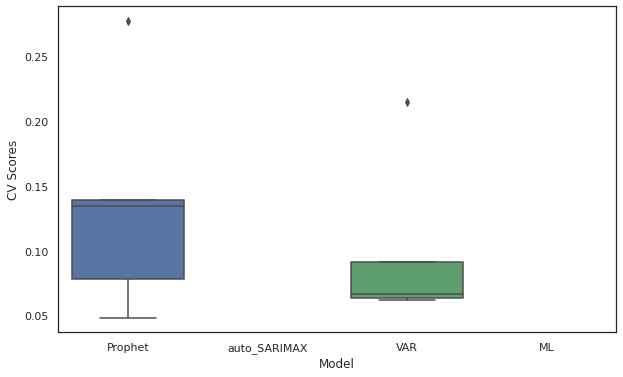

In [63]:
automl_model.plot_cv_scores()

Building Forecast dataframe. Forecast Period = 17


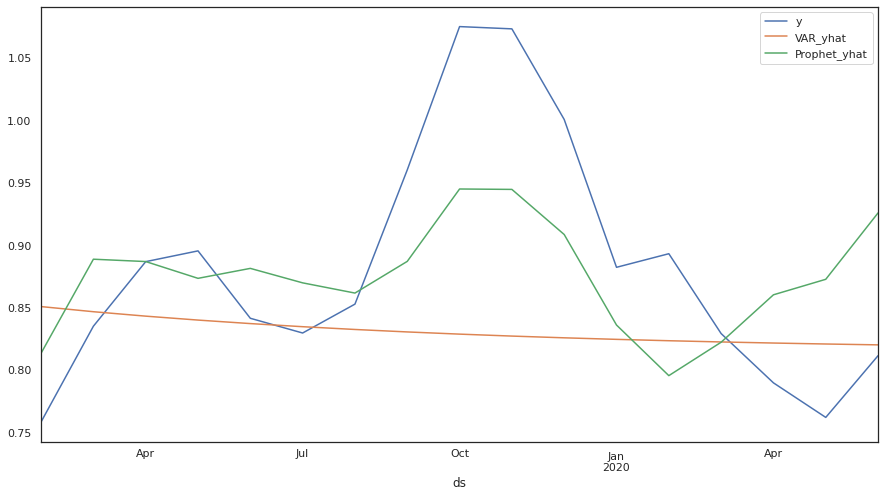

In [64]:
subm = test_fb[['ds',target]].copy()
for model in ['VAR', 'Prophet']:
    future_predictions = automl_model.predict(
        testdata=test_fb,
        model=model
    )
    subm[model+'_yhat'] = future_predictions['yhat'].values

subm.set_index('ds', inplace=True)
subm.plot(figsize=(15,8))

In [60]:
automl_model.predict(3, model ='VAR')

y,yhat,mean_se,mean_ci_lower,mean_ci_upper
2020-07-01,0.850783,0.052142,0.748587,0.952980
2020-08-01,0.846673,0.070286,0.708916,0.984430
2020-09-01,0.843128,0.081837,0.682731,1.003525


# 6. Testing Causation using Granger’s Causality Test
The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

So what does Granger’s Causality really test?

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

The below code implements the Granger’s Causality test for all possible combinations of the time series in a given dataframe and stores the p-values of each combination in the output matrix.

In [354]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False,)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,StainlessSteelPrice_x,Steel_Inventory_M_USD_x,Steel_Orders_M_USD_x,IronOre_Global_USD_x,CoalAustralia_Global_USD_x,Energy_Index_x,Nickel_Global_USD_x,Zinc_Global_USD_x,Freight_Transport_Index_x,WTI_Crude_Global_USD_x,Baltic_Dry_Index_x,BCI_China_x,BCI_Europe_x,BCI_US_x,CLI_China_x,CLI_Europe_x,CLI_US_x,PMI_US_Manufacturing_x,Copper_Global_USD _x
StainlessSteelPrice_y,1.0000,0.1204,0.0001,0.0131,0.0520,0.0183,0.0000,0.0001,0.4200,0.0032,0.0324,0.0139,0.1156,0.1097,0.1056,0.5341,0.2803,0.1909,0.0000
Steel_Inventory_M_USD_y,0.0000,1.0000,0.0000,0.0101,0.0000,0.0000,0.0004,0.0000,0.0002,0.0000,0.0003,0.0001,0.0001,0.0000,0.0995,0.0001,0.0000,0.0000,0.0000
Steel_Orders_M_USD_y,0.0000,0.0079,1.0000,0.0313,0.0016,0.0000,0.0000,0.0054,0.0001,0.0000,0.0152,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0006,0.0000
IronOre_Global_USD_y,0.0391,0.0802,0.2258,1.0000,0.0196,0.2834,0.0179,0.0267,0.0292,0.2697,0.0109,0.0093,0.1046,0.0003,0.0965,0.0000,0.0039,0.0005,0.4108
CoalAustralia_Global_USD_y,0.0367,0.0041,0.0368,0.0060,1.0000,0.1839,0.2175,0.0033,0.0003,0.2017,0.5499,0.0195,0.0001,0.0000,0.0952,0.0039,0.0219,0.0065,0.0316
Energy_Index_y,0.0000,0.0250,0.0699,0.2774,0.0703,1.0000,0.0000,0.2087,0.0396,0.0057,0.1240,0.0000,0.0053,0.0025,0.0000,0.0449,0.0638,0.0039,0.0558
Nickel_Global_USD_y,0.0274,0.0225,0.0000,0.0016,0.0548,0.0071,1.0000,0.1179,0.4878,0.0067,0.0800,0.2350,0.0407,0.3486,0.1977,0.7652,0.1509,0.1722,0.0083
Zinc_Global_USD_y,0.0003,0.0001,0.0000,0.3818,0.2035,0.0116,0.0002,1.0000,0.1058,0.0379,0.4791,0.0004,0.1751,0.0047,0.0177,0.4257,0.0000,0.0171,0.0011
Freight_Transport_Index_y,0.0497,0.0026,0.0015,0.0054,0.1265,0.0001,0.0407,0.0092,1.0000,0.0001,0.0193,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0166,0.0213
WTI_Crude_Global_USD_y,0.0000,0.0713,0.2111,0.1844,0.1559,0.0001,0.0000,0.1195,0.0696,1.0000,0.0961,0.0000,0.0324,0.0060,0.0000,0.0135,0.0021,0.0027,0.0690


If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

For example, P-Value of 0.0003 at (row 1, column 2) represents the p-value of the Grangers Causality test for pgnp_x causing rgnp_y, which is less that the significance level of 0.05.

So, you can reject the null hypothesis and conclude pgnp_x causes rgnp_y.

Looking at the P-Values in the above table, you can pretty much observe that all the variables (time series) in the system are interchangeably causing each other.

This makes this system of multi time series a good candidate for using VAR models to forecast.

In [355]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    #print(f' Test Statistic        = {output["test_statistic"]}')
    #print(f' No. Lags Chosen       = {output["n_lags"]}')

    #for key,val in r[4].items():
    #    print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [356]:
# ADF Test on each column
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "StainlessSteelPrice" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.1574. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Steel_Inventory_M_USD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.0126. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Steel_Orders_M_USD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.2353. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "IronOre_Global_USD" 
    -----------------------------------------------
 Null Hypothesis: Data has un

In [357]:
# 1st difference
df_differenced = df.diff().dropna()

In [358]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "StainlessSteelPrice" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Steel_Inventory_M_USD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Steel_Orders_M_USD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IronOre_Global_USD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

In [26]:
#test_length = 20
def train_test_df(df, train_len = 12, horizon = 3, fold = 5, fold_i = 1):
    #split_date = "2020-02-01"
    #train_filt = df.index <= split_date
    #test_filt = df.index > split_date
    test_end = horizon*(fold_i-1)
    test_start = test_end + horizon
    train_end = test_start
    train_start = train_end + train_len 
    train_df = df.copy().iloc[-train_start:-train_end,:]#[train_filt]
    if test_end ==0:
        test_df = df.copy().iloc[-test_start:,:] #[test_filt]
    else: 
        test_df = df.copy().iloc[-test_start:-test_end,:] #[test_filt]

    #print("train data shape :", train_df.shape[0] )
    #print("test data shape :", test_df.shape[0] )
    return train_df, test_df

In [27]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    
    df_fc.drop(columns = [col for col in df_fc.columns if 'forecast' not in col] , inplace = True, axis = 1)
    return df_fc

In [29]:
def run_VAR_model(train_df, test_df, diff_order, maxlag, target = 'StainlessSteelPrice'):
    if len(train_df)< diff_order+maxlag+5:
        print('len(train_df) must be >= diff_order+maxlag+5')
    else:


        # Input data for forecasting
        if diff_order == 1:
            model = VAR(train_df.diff().diff().dropna())    
            model_fitted = model.fit( maxlag)
            # Get the lag order
            lag_order = model_fitted.k_ar
            forecast_input = train_df.diff().dropna().values[-lag_order:]
        if diff_order == 2:
            model = VAR(train_df.diff().diff().dropna())    
            model_fitted = model.fit( maxlag)
            # Get the lag order
            lag_order = model_fitted.k_ar
            forecast_input = train_df.diff().diff().dropna().values[-lag_order:]
        
        nobs = len(test_df)
        fc = model_fitted.forecast(y=forecast_input, steps=nobs)
        df_forecast = pd.DataFrame(fc, index=test_df.index[-nobs:], columns=test_df.columns + '_' + str(diff_order) + 'd')
        if diff_order == 1:
            df_results = invert_transformation(train_df, df_forecast, second_diff=False)        
        if diff_order == 2:
            df_results = invert_transformation(train_df, df_forecast, second_diff=True)

        y_hat = df_results[target+'_forecast']
        y = test_df[target][-nobs:]
        metrics = forecast_accuracy(y_hat, y)
        return y_hat, metrics


In [30]:
def run_VAR_cv(df,horizon, num_folds, lag, diff, target, metric='mape'):
    cv_metrics = []
    for i in range(1, num_folds+1):
        train_df , test_df = train_test_df(df, train_len = lag+diff+5, horizon = horizon, fold = num_folds, fold_i = i)
        _, metrics = run_VAR_model(train_df, test_df, diff_order=diff, maxlag=lag, target=target)
        #print('fold ' + str(i))
        print(metrics)
        cv_metrics.append(metrics[metric])
    print('average cross validated '+ metric + ' is >>>>>>>>>>>>>>>>>>>>>>>>>>>> ' )
    return np.mean(cv_metrics)

In [487]:
target = 'StainlessSteelPrice'
num_folds = 15
horizon = 3
for maxlag in range(4,25):
    print('maxlag = ', str(maxlag))
    metric =    run_VAR_cv(df,horizon, num_folds, maxlag, diff=2, target = target, metric='mape')
    print(metric)
    print('-' * 150)

maxlag =  4
{'mape': 0.09882621998121684, 'mae': 0.07819478938916864, 'mpe': -0.09882621998121684, 'rmse': 0.08528827244052206}
{'mape': 0.09630976914764133, 'mae': 0.08046885794711685, 'mpe': 0.09630976914764133, 'rmse': 0.12315695467405077}
{'mape': 0.033767733042637145, 'mae': 0.03470324851437848, 'mpe': 0.033767733042637145, 'rmse': 0.04338055303155609}
{'mape': 0.08960139721200916, 'mae': 0.08129009644354031, 'mpe': -0.08960139721200916, 'rmse': 0.09217397487918694}
{'mape': 0.019590887174366505, 'mae': 0.01744446833728745, 'mpe': -0.017589083320832404, 'rmse': 0.022487248346207068}
{'mape': 0.058825621296349356, 'mae': 0.048259032928505974, 'mpe': -0.03491867949357348, 'rmse': 0.06597661908538675}
{'mape': 0.05307300435256307, 'mae': 0.04508725350962165, 'mpe': -0.049459341605744056, 'rmse': 0.0641678107848615}
{'mape': 0.08000624049159322, 'mae': 0.07841713651994686, 'mpe': 0.06890042956843782, 'rmse': 0.09384560275954128}
{'mape': 0.025083351383983172, 'mae': 0.0243136134938100

In [460]:
model = VAR(df.diff().diff().dropna())
for i in range(1,24):
    result = model.fit(i)
    print('Lag Order =', i)
    try:
      print('AIC : ', result.aic)
      print('BIC : ', result.bic)
      print('HQIC: ', result.hqic, '\n')
    except:
      pass

Lag Order = 1
AIC :  53.79224067159842
BIC :  65.02545892808641
HQIC:  58.29915503505284 

Lag Order = 2
AIC :  41.590114997518356
BIC :  63.653636701185185
HQIC:  50.436012188572334 

Lag Order = 3
AIC :  25.126835592076574
BIC :  58.179133483451984
HQIC:  38.368597365126575 

Lag Order = 4
Lag Order = 5
AIC :  -945.1065159316671
BIC :  -889.5857225620422
HQIC:  -922.8986863324685 

Lag Order = 6
AIC :  -992.6172521072897
BIC :  -925.6086685740577
HQIC:  -965.8373809134932 

Lag Order = 7
AIC :  -1018.6842699938146
BIC :  -940.0132734996353
HQIC:  -987.2718049631709 

Lag Order = 8
AIC :  -1036.3961495380079
BIC :  -945.8837545928116
HQIC:  -1000.289642379741 

Lag Order = 9
AIC :  -1037.4064940544413
BIC :  -934.8692138671406
HQIC:  -996.5436169665242 

Lag Order = 10
AIC :  -1043.8977401069292
BIC :  -929.1474436359672
HQIC:  -998.215307275001 

Lag Order = 11
AIC :  -1050.1796195698926
BIC :  -923.0233842263033
HQIC:  -999.6136143295989 

Lag Order = 12
AIC :  -1053.0787713375735
B

In [466]:
from statsmodels.stats.stattools import durbin_watson

model_fitted = model.fit( 7)
#model_fitted.summary()
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

StainlessSteelPrice : 2.38
Steel_Inventory_M_USD : 2.93
Steel_Orders_M_USD : 2.69
IronOre_Global_USD : 1.93
CoalAustralia_Global_USD : 2.51
Energy_Index : 2.59
Nickel_Global_USD : 1.93
Zinc_Global_USD : 2.65
Freight_Transport_Index : 2.67
WTI_Crude_Global_USD : 2.83
Baltic_Dry_Index : 2.6
BCI_China : 2.39
BCI_Europe : 2.13
BCI_US : 2.59
CLI_China : 2.75
CLI_Europe : 2.44
CLI_US : 2.57
PMI_US_Manufacturing : 2.17
Copper_Global_USD  : 2.55


In [492]:
# Input data for forecasting
train_df , test_df = train_test_df(df, train_len = 14, horizon = 3, fold = 5, fold_i = 1)

model = VAR(train_df.diff().diff().dropna())
model_fitted = model.fit( 7)
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

forecast_input = train_df.diff().diff().dropna().values[-lag_order:]


7


In [493]:
# Forecast
nobs = len(test_df)
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=test_df.index[-nobs:], columns=test_df.columns + '_2d')


In [499]:
df_results = invert_transformation(train_df, df_forecast, second_diff=True)
df_results['StainlessSteelPrice_naive'] = train_df['StainlessSteelPrice'].iloc[-3:].values        
df_results.head(1)


,StainlessSteelPrice_forecast,Steel_Inventory_M_USD_forecast,Steel_Orders_M_USD_forecast,IronOre_Global_USD_forecast,CoalAustralia_Global_USD_forecast,Energy_Index_forecast,Nickel_Global_USD_forecast,Zinc_Global_USD_forecast,Freight_Transport_Index_forecast,WTI_Crude_Global_USD_forecast,Baltic_Dry_Index_forecast,BCI_China_forecast,BCI_Europe_forecast,BCI_US_forecast,CLI_China_forecast,CLI_Europe_forecast,CLI_US_forecast,PMI_US_Manufacturing_forecast,Copper_Global_USD _forecast,StainlessSteelPrice_naive
Date,,,,,,,,,,,,,,,,,,,,
2020-04-01,0.770528,20208.106779,8212.93398,96.081963,70.42736,41.542809,11031.708911,1755.268216,-0.153176,11.132349,589.292817,99.069451,96.703142,98.182935,104.229063,94.374769,95.856299,47.509756,4866.351394,0.882237


In [503]:
rmse =  sqrt(mean_squared_error(test_df[target][-nobs:] ,  df_results[target+'_forecast']))
print('VAR forecast rmse >>>> ', str(rmse) )
rmse =  sqrt(mean_squared_error(test_df[target][-nobs:] ,  df_results[target+'_naive']))
print('Naive forecast rmse >>>> ', str(rmse))

VAR forecast rmse >>>>  0.08980585942338443
Naive forecast rmse >>>>  0.09320118346147181


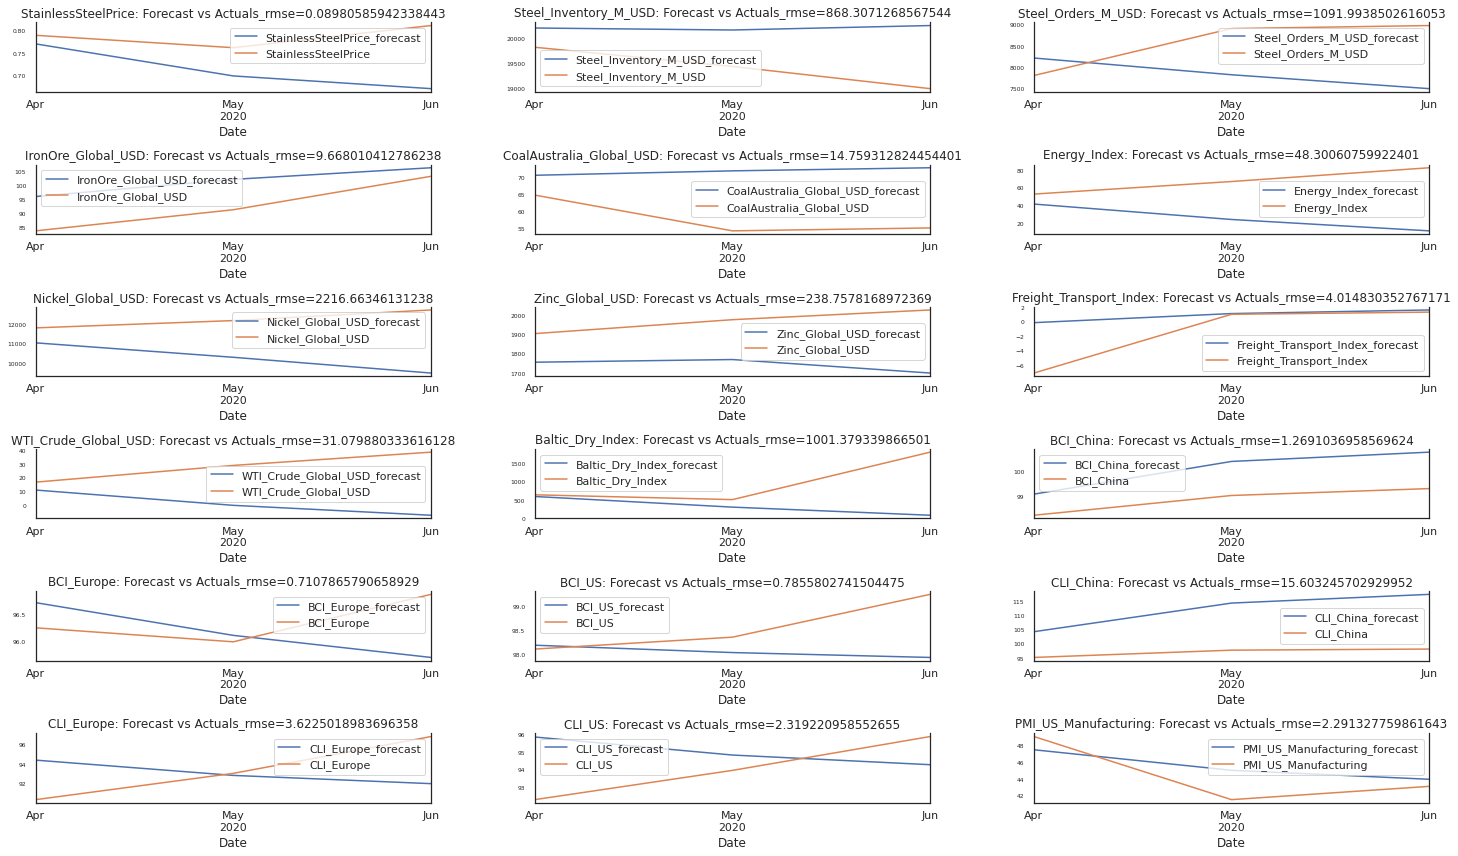

In [491]:
from sklearn.metrics import mean_squared_error
from math import sqrt

fig, axes = plt.subplots(nrows=int(len(df.columns)/3), ncols=3, figsize=(21,12))

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_df[col][-nobs:].plot(legend=True, ax=ax);
    rmse =  sqrt(mean_squared_error(test_df[col][-nobs:] ,  df_results[col+'_forecast']))
    ax.set_title(col + ": Forecast vs Actuals_rmse=" + str(rmse) )
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

<a name="Data_Distributions"></a>

# Data Distributions:

The following are the bar plot of the values in each column to get an idea of their data distributions. 

Looking at the target `'will_be_executive'` plot we can see the data is imbalanced. So either used some up/down sampling techniques (like `SMOTE`) to balance the two classes in the target column or use some sort of uneven weights for `cost/loss` functions to put more emphasis on less frequent class. 

The other observation is the huge number of rows with `0` (i.e. `'unknown'`) values in `['career_level', 'discipline_id', 'company_size']`. Since `30-60%` of these features are `unknown`, some imputation technique are tried to fill the missing values.

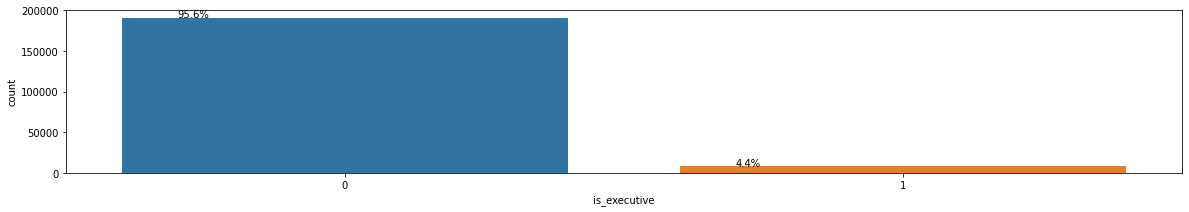

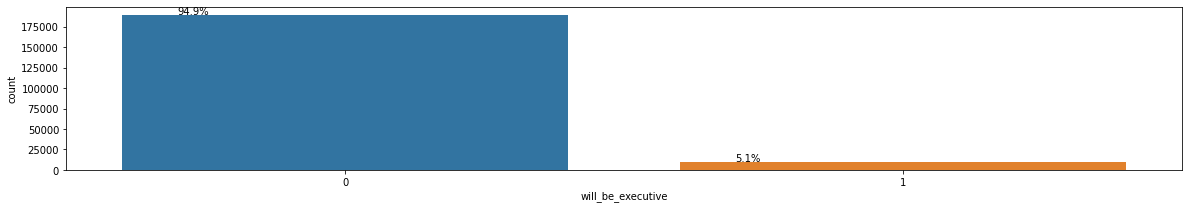

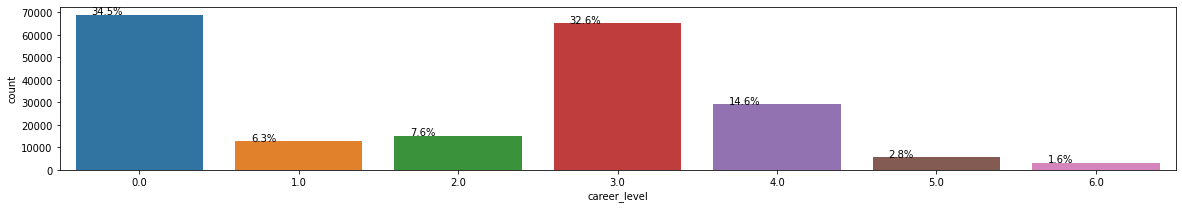

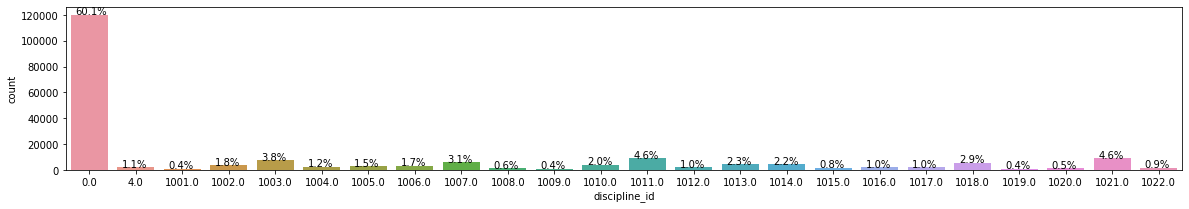

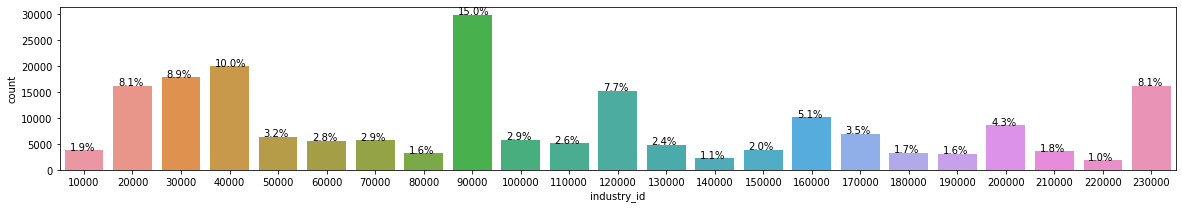

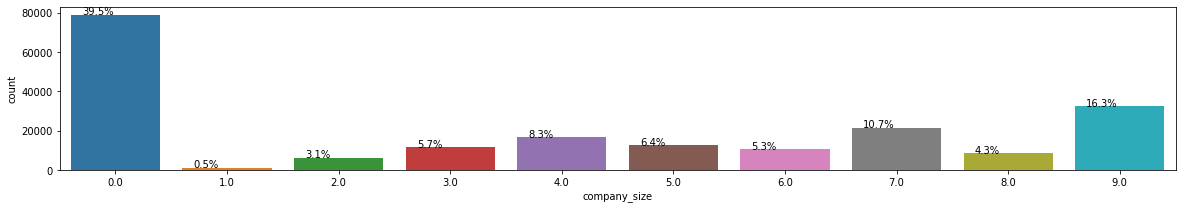

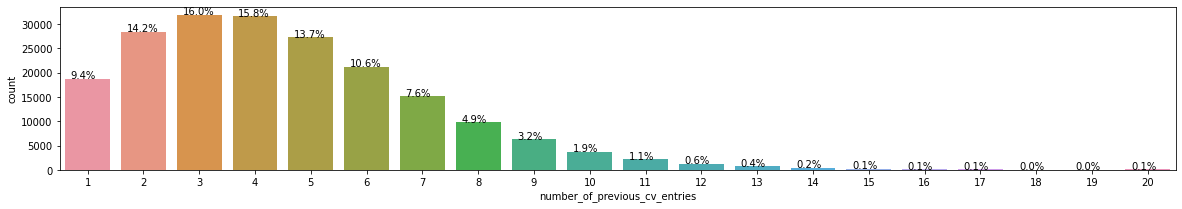

In [ ]:

for name in ["is_executive","will_be_executive", "career_level", "discipline_id", "industry_id", 'company_size', 'number_of_previous_cv_entries' ]:

    plt.rcParams["figure.figsize"] = [20, 3]  # width, height
    ax = sns.countplot(x=name, data=df, )
    total = len(df)*1.
    for p in ax.patches:
            ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
    plt.show()
    print('='* 150)

Before resampling/encoding data, I replaced all the `0` values with `np.nan` as they are `unknown`. Later on, they will be imputed.

In [ ]:
df = df.astype({"is_executive":'category', 
                "career_level":'int64', 
                "discipline_id":'category', 
                "jobrole_id":'int64', 
                'industry_id':'category', 
                'company_size':'int64', 
                'number_of_previous_cv_entries':'int64', 
                'will_be_executive':'category'})

print('='* 100)
for name in ['career_level', 'discipline_id', 'jobrole_id', 'industry_id', 'company_size']:
    print('replacing 0 with np.nan in >>>>> ', name)
    df.loc[df[name]==0,name] = np.nan

print('='* 100)
print(' ')
print('percentage of unknown/missing values in each column:')
null_percentage = df.isnull().sum() * 100 / len(df)
print(null_percentage)

print('='* 100)
print(' ')
print('shape of the dataframe if we drop rows containing np.nan :')    
print( df.dropna().shape )

replacing 0 with np.nan in >>>>>  career_level
replacing 0 with np.nan in >>>>>  discipline_id
replacing 0 with np.nan in >>>>>  jobrole_id
replacing 0 with np.nan in >>>>>  industry_id
replacing 0 with np.nan in >>>>>  company_size
 
percentage of unknown/missing values in each column:
is_executive                      0.0000
career_level                     34.5170
discipline_id                    60.1435
jobrole_id                        0.0000
industry_id                       0.0000
company_size                     39.4930
number_of_previous_cv_entries     0.0000
will_be_executive                 0.0000
dtype: float64
 
shape of the dataframe if we drop rows containing np.nan :
(47822, 8)


<a name="Encodings"></a>
# Encodings

Also to feeding the categorical variables to the models, we need to encode them.
Encoding the categorical features are done using `BinaryEncoder` from `category_encoders` libraries which , compared to `one-hot-encodding`, has the benefit of reducing the number of dummy features.

Although `'career_level'` is in fact a categorical variable, since it is ordinal I kept it as it is (integer) and did not encode it.

One important point before performing resampling/encoding is that, to prevent data leakage, the `train` and `test` rows are seperated and the resampler/encoder fit on the `train` data only then the fitted models are used to resample/encode the `test` features. `train/test` split ratio of `75/25` is used in this study although for a more comprehensive analysis `cross-validation` might be a much more robust method.

In [ ]:
# Randomly sample 75% of your dataframe for train
train = df.sample(frac=0.75, random_state=1).copy()
test = df.drop(index = train.index).copy()


def encode(train, test, columns):
    """
    INPUTS:
        train and test dataframes and the list of categorical columns to encode
        encoder fits on train dataframe and encodes both train and test
    RETURNS:
        train and test dataframes with dummy variables replacing categorical columns.
        The number of dummy variables are less than One-hot-encoding
    """ 
    #Create object for binary encoding
    encoder= ce.BinaryEncoder(cols=columns, return_df=True ,handle_unknown='return_nan')
    #Fit and Transform Data 
    train_encoded=encoder.fit_transform(train)
    test_encoded= encoder.transform(test)
    # remove the constant encoded features:
    test_encoded = test_encoded.loc[:,test_encoded.apply(pd.Series.nunique) != 1]
    train_encoded = train_encoded.loc[:,train_encoded.apply(pd.Series.nunique) != 1]
    return train_encoded, test_encoded 


train_encoded, test_encoded = encode(train, test, ['jobrole_id', 'industry_id','discipline_id'])

print('='* 150)
print(' ')
print('percentage of unknown/missing values in each column:')
null_percentage = train_encoded.isnull().sum() * 100 / len(train_encoded)
print(null_percentage)

 
percentage of unknown/missing values in each column:
is_executive                      0.000000
career_level                     34.467333
discipline_id_1                  60.152667
discipline_id_2                  60.152667
discipline_id_3                  60.152667
discipline_id_4                  60.152667
discipline_id_5                  60.152667
jobrole_id_1                      0.000000
jobrole_id_2                      0.000000
jobrole_id_3                      0.000000
jobrole_id_4                      0.000000
jobrole_id_5                      0.000000
jobrole_id_6                      0.000000
jobrole_id_7                      0.000000
jobrole_id_8                      0.000000
jobrole_id_9                      0.000000
jobrole_id_10                     0.000000
jobrole_id_11                     0.000000
industry_id_1                     0.000000
industry_id_2                     0.000000
industry_id_3                     0.000000
industry_id_4                     0.000000

In [ ]:
# Define features (X) and target(Y) dataframes for train and test:
target = 'will_be_executive'
Y_train = train_encoded[target]
X_train = train_encoded[[name for name in train_encoded.columns if name != target ]]
Y_test = test_encoded[target]
X_test = test_encoded[[name for name in test_encoded.columns if name != target ]]

<a name="Imputing"></a>
# Imputing

Various imputation technique are available in `sklearn`. The most advanced method in the data science community is `'MICE'`. `'knn'` imputer is slow as it need to find the distance to all other data points. I varied the imputation methods for this dataset and it did not have noticable effect on the model performances.

Again, to prevent data leakage, the imputers are trained on the `train` dataframe and then transformed the `test` dataframe.

In [ ]:
def Impute(X1, X2, method='mean'):
    """
    INPUTS:
        X1, X2 dataframes which have missing values and the imputation method
    RETURNS:
        X1, X2 numpy arrays imputed by the imputer
    """ 
    if method == 'mean':
        imp = SimpleImputer(strategy='mean')
    if method == 'median':
        imp = SimpleImputer(strategy='median')
    if method == 'most_frequent':
        imp = SimpleImputer( strategy='most_frequent')
    if method == 'constant':
        imp = SimpleImputer(strategy='constant', fill_value=0)
    if method == 'mice':
        imp = IterativeImputer(random_state=0)
    if method == 'knn':
        imp = KNNImputer()
    X_1 = imp.fit_transform(X1)
    X_2 = imp.transform(X2)
    return X_1, X_2

# imputing
X_train, X_test = Impute(X_train, X_test, 'median')

<a name="Resampling"></a>
# Resampling

Since we have class imbalance, I used `SMOTE` to down sample the majority class and upsample the minority. As mentioned in a [paper](https://arxiv.org/abs/1106.1813), it is believed that `SMOTE` performs better when combined with undersampling of the majority class, such as random undersampling.
I will first oversample the minority class with `SMOTE` to about a `2:10` ratio, then undersample the majority class to achieve about a `3:10` ratio.


In [ ]:

# SMOTE Over sampling as well as random undersampling
def resample(X_train, Y_train, over_ratio = 0.2, under_ratio = 0.3, random_state = 100):
    """
    INPUTS:
        X_train, Y_train dataframes which are feature/target dataframes with
        imbalanced data
        over_ratio is the ratio of minority/majority after over sampling the minority class
        under_ratio is the ratio of minority/majority after under sampling the majority class
    RETURNS:
        X_train, Y_train numpy arrays with balanced classes
    """   
    print('initial number of rows: ', X_train.shape[0])
    over = SMOTE(sampling_strategy= over_ratio, random_state=random_state)
    X_train, Y_train = over.fit_resample(X_train, Y_train)
    print('number of rows after over sampling: ', X_train.shape[0])
    under = RandomUnderSampler(sampling_strategy=under_ratio,random_state=random_state)
    X_train, Y_train = under.fit_resample(X_train, Y_train)
    print('final number of rows after under sampling: ', X_train.shape[0])
    return X_train, Y_train

X_train, Y_train = resample(X_train, Y_train, over_ratio = 0.2, under_ratio = 0.3, random_state = 100)

initial number of rows:  150000
number of rows after over sampling:  170779
final number of rows after under sampling:  123339


One method of compensating for class imbalance (instead of resampling) is defining class weight dictionary which allows for setting larger penalties on misclassification of the minority class. Below, I showed one method of setting imbalanced weights for calculating loss function. The weights are inversely proportional with the original dataframe's counts per class. So the minority class will have more weight for wrong predictions.

In [ ]:
counts = np.bincount(df[target])
print("Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(df)))

weight_for_0 = counts[1] / len(df)
weight_for_1 = counts[0] / len(df)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

Number of positive samples in training data: 10158 (5.08% of total)
{0: 0.05079, 1: 0.94921}


For the rest of this notebook since I already tried to solve the imbalanced classes issue by resampling, I will set both class weights equal. but in theory it can be adjusted to the level that works best for our application.

In [ ]:
class_weight = {0: 0.5, 1: 0.5}
print(class_weight)

{0: 0.5, 1: 0.5}


<a name="Metrics"></a>
# Metrics

Since in the challenge description it is mentioned that senior level people might get offended by getting junior level jobs, the `False Negative rate` must be emphesised in the metric definition. Generally `F1` scores are used as a good balance between recall and precision. But here given the situation, I think `F2` along with `ROC AUC score` might be a better choice as it puts more attention on minimizing false negatives and the minority class.



In [ ]:
def metrics(Y_test, Y_pred_prob, threshold, verbose = True):
    """
    INPUTS:
        Y_test, Y_pred_prob dataframes which are target/prediction/prediction_probability
    RETURNS:
        f1,f2, roc_auc scores
    """ 
    Y_pred = (Y_pred_prob > threshold).astype('float')
    df_table = confusion_matrix( Y_test,Y_pred)
    TP =  df_table[1,1]
    TN =  df_table[0,0]
    FP =  df_table[0,1] 
    FN =  df_table[1,0] 
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    acc = (TN + TP) / (TN + FN + FP + TP)
    specificity = TN/(TN + FP)
    f1 = (2*p*r)/(p+r)
    f2 = (5*p*r)/(4*p+r)
    roc_auc = roc_auc_score(Y_test,Y_pred_prob)
    gmeans =  np.sqrt(r * specificity) #np.sqrt(tpr * (1-fpr))
    
    output = {
        'Threshold' : threshold,
        'TP' : TP,
        'FP' : FP,
        'TN' : TN,
        'FN' : FN,
        'accuracy' : acc,
        'precision': p,
        'recall': r,
        'specificity': specificity,
        'F1 score' : f1,
        'F2 score': f2,
        'GMeans': gmeans,
        'roc_auc_score': roc_auc
    }
    if verbose:
        print(output)
    return output

### Plotting Funtions

The two function below will plot `precision-recall` and `ROC` curves and return the corresponding optimal scores. They will find the optimal score while varying the threshold value (i.e. threshold that we use to convert probability to binary class labels). All main metrics are returned at the optimal threshold.

**Note that for this data set that is imbalanced and False Negative rate should be small, using `pr_curve` with `F2` score seems to be a better choice. This selection will put more emphesis on the minority class. Therefore the following modeling steps are focused on `F2` scores from `plot_pr_curve` function.**

In [ ]:
def plot_pr_curve(testy , yhat, label, score_type = 'F2'):
    """
    This function takes in target and prediction of a binary classification mode
    and plots the precision-recall curve and finds the maximum score point by
    varying the thereshold of the classification labels.
    INPUTS:
        testy , yhat numpy array which are the target for a model and its probability prediction
        label is the label of the plot
        score_type is string determining the type of score to maximize
    RETURNS:
        precision-recall curve and the optimal thereshold and the other metrics in that threshold
    """ 
    plt.rcParams["figure.figsize"] = [4, 4]  # width, height
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(testy, yhat)
    # convert to f score
    if score_type == 'F1':
        fscore = (2 * precision * recall) / (precision + recall)
    if score_type == 'F2':
        fscore = (5 * precision * recall) / (4*precision + recall)
    # locate the index of the largest f score
    # since we want large recalls, for finding the largest f-score first get rid of the small recalls.
    sub_fscore = fscore[recall > 0.2]
    ix, = np.where(fscore == np.max(sub_fscore) )[0] # integers

    #ix = np.argmax(fscore)
    # plot the roc curve for the model
    no_skill = len(testy[testy==1]) / len(testy)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label= label)
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best', linewidths=4)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(' Best Threshold=%f, %s-Score=%.3f' % (thresholds[ix], score_type, fscore[ix]))
    plt.legend()
    # show the plot
    plt.show()
    print(' Best Threshold=%f, %s-Score=%.3f' % (thresholds[ix], score_type, fscore[ix]))
    output =  metrics(testy, yhat, thresholds[ix], verbose = True)
    return output

def plot_roc_curve(testy,yhat, label):
    """
    This function takes in target and prediction of a binary classification mode
    and plots the ROC curve and finds the maximum Gmeans score point by
    varying the thereshold of the classification labels.
    INPUTS:
        testy , yhat numpy array which are the target for a model and its probability prediction
        label is the label of the plot
    RETURNS:
        ROC curve and the optimal thereshold and the other metrics in that threshold
    """ 
    plt.rcParams["figure.figsize"] = [4, 4]  # width, height
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(testy, yhat)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= label)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best', linewidths=4 )
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(' Best Threshold=%f, G-Mean-Score=%.3f' % (thresholds[ix], gmeans[ix]))
    plt.legend()
    # show the plot
    plt.show()
    print( ' Best Threshold=%f, G-Mean-Score=%.3f' % (thresholds[ix], gmeans[ix]) )
    output =  metrics(testy, yhat, thresholds[ix], verbose = True)
    return output



<a name="Modeling"></a>
# Modeling

Here multiple binary classification algorithm are implemented and their scores are reported. Obviously there are huge opportunities to improve their performances by tunning hyperparameteres but here I tried to stick to default setting as the time of this challeng is limitted.

### Standardize the data using training set statistics

Before feeding the dataset into the models, I standardized them.


In [ ]:
def standarize(X_1, X_2):
    """
    INPUTS:
        X_1, X_2 numpy array which get standardized (i.e. mean = 0, std = 1)
        mean is calculated based on X_1
    RETURNS:
        X_1, X_2 standard numpy array
    """ 
    mean = np.mean(X_1, axis=0)
    X_1 -= mean
    X_2 -= mean
    std = np.std(X_1, axis=0)
    X_1 /= std
    X_2 /= std
    return X_1, X_2

X_train, X_test = standarize(X_train, X_test)

### Logistic Regression

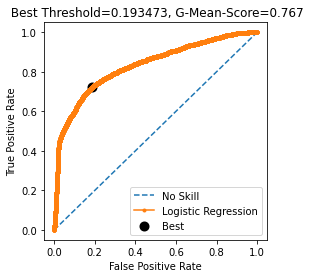

 Best Threshold=0.193473, G-Mean-Score=0.767
{'Threshold': 0.1934727213697143, 'TP': 1793, 'FP': 8945, 'TN': 38581, 'FN': 681, 'accuracy': 0.80748, 'precision': 0.16697709070590427, 'recall': 0.7247372675828617, 'specificity': 0.81178723225182, 'F1 score': 0.27141992128368153, 'F2 score': 0.43447707666957447, 'GMeans': 0.7670283310027329, 'roc_auc_score': 0.8324005035102942}


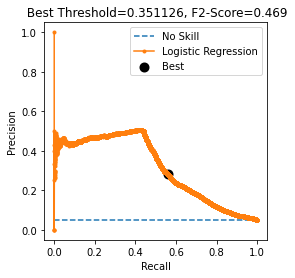

 Best Threshold=0.351126, F2-Score=0.469
{'Threshold': 0.3511258186392641, 'TP': 1381, 'FP': 3466, 'TN': 44060, 'FN': 1093, 'accuracy': 0.90882, 'precision': 0.2849185062925521, 'recall': 0.5582053354890865, 'specificity': 0.9270714977065185, 'F1 score': 0.3772708646359787, 'F2 score': 0.46835786474937263, 'GMeans': 0.7193721265100818, 'roc_auc_score': 0.8324005035102942}


In [ ]:
def logistic(X_train, Y_train, X_test, Y_test, class_weight=None, verbose = True):
    lr = LogisticRegression(class_weight=class_weight)
    lr.fit(X_train,Y_train)
    Y_pred = lr.predict(X_test)
    Y_pred_prob = lr.predict_proba(X_test)[:,1]
    if verbose:
        out1 = plot_roc_curve(Y_test, Y_pred_prob, label = 'Logistic Regression')
        out2 = plot_pr_curve(Y_test, Y_pred_prob, label = 'Logistic Regression', score_type='F2')      
    return out1, out2

lr_out1, lr_out2 = logistic(X_train,Y_train, X_test,Y_test, class_weight=class_weight)

### Naive Bayesian

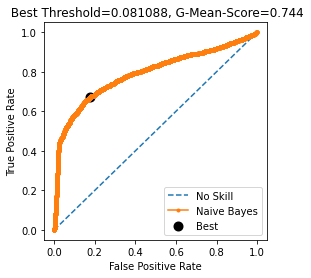

 Best Threshold=0.081088, G-Mean-Score=0.744
{'Threshold': 0.0810884033261557, 'TP': 1665, 'FP': 8470, 'TN': 39056, 'FN': 809, 'accuracy': 0.81442, 'precision': 0.16428219042920572, 'recall': 0.6729991915925626, 'specificity': 0.8217817615620924, 'F1 score': 0.26409707351891504, 'F2 score': 0.4156058109929609, 'GMeans': 0.7436790041387482, 'roc_auc_score': 0.7924030673964413}


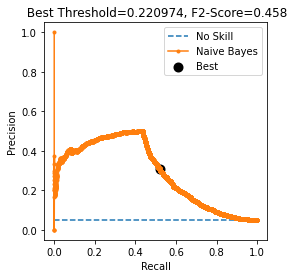

 Best Threshold=0.220974, F2-Score=0.458
{'Threshold': 0.22097376564064783, 'TP': 1286, 'FP': 2861, 'TN': 44665, 'FN': 1188, 'accuracy': 0.91902, 'precision': 0.31010368941403427, 'recall': 0.5198059822150364, 'specificity': 0.9398013718806548, 'F1 score': 0.3884609575592811, 'F2 score': 0.45787937050487787, 'GMeans': 0.6989380338752946, 'roc_auc_score': 0.7924030673964413}


In [ ]:
def NB(X_train, Y_train, X_test, Y_test, verbose = True):
    nb = GaussianNB( )
    nb.fit(X_train,Y_train)
    Y_pred = nb.predict(X_test) 
    Y_pred_prob = nb.predict_proba(X_test)[:,1]
    if verbose:
        out1 = plot_roc_curve(Y_test, Y_pred_prob, label = 'Naive Bayes')
        out2 = plot_pr_curve(Y_test, Y_pred_prob, label = 'Naive Bayes', score_type='F2')      
    return out1, out2

nb_out1, nb_out2 = NB(X_train,Y_train, X_test,Y_test)

### Support Vector Machine and KNN

SVM's do not naturally produce probabilities for final-predictions. These two algorithm are also very slow so I just included their code but not really run them.

In [ ]:
#from sklearn import svm

#sv = svm.SVC(kernel="rbf", C=0.025,random_state=101)
#sv.fit(X_train, Y_train)

#Y_pred = sv.predict(X_test)
#Y_pred_prob = sv.predict_proba(X_test)[:,1]
#metrics(Y_test, Y_pred,Y_pred_prob, verbose)

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier

#knn = KNeighborsClassifier(n_neighbors=3)
#knn.fit(X_train,Y_train)
#Y_pred=knn.predict(X_test)
#metrics(Y_test, Y_pred)

### Stochastic Gradient Descent Classifier

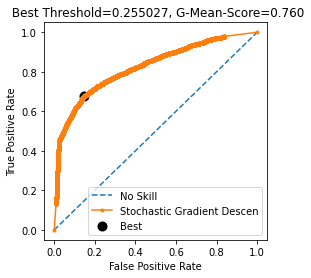

 Best Threshold=0.255027, G-Mean-Score=0.760
{'Threshold': 0.2550265353505222, 'TP': 1674, 'FP': 6944, 'TN': 40582, 'FN': 800, 'accuracy': 0.84512, 'precision': 0.19424460431654678, 'recall': 0.6766370250606305, 'specificity': 0.853890502040988, 'F1 score': 0.3018391633609809, 'F2 score': 0.4520903100356487, 'GMeans': 0.76011441837959, 'roc_auc_score': 0.8243221656896071}


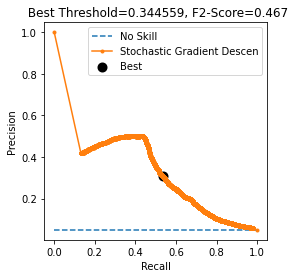

 Best Threshold=0.344559, F2-Score=0.467
{'Threshold': 0.3445590280938065, 'TP': 1322, 'FP': 2939, 'TN': 44587, 'FN': 1152, 'accuracy': 0.91818, 'precision': 0.3102558084956583, 'recall': 0.534357316087308, 'specificity': 0.9381601649623365, 'F1 score': 0.3925760950259837, 'F2 score': 0.46690683054319415, 'GMeans': 0.7080344255820477, 'roc_auc_score': 0.8243221656896071}


In [ ]:
def SGD(X_train, Y_train, X_test, Y_test , class_weight=None, verbose = True):
    sgd =  SGDClassifier(loss='modified_huber', shuffle=True,random_state=1, class_weight=class_weight, max_iter=1000, tol=1e-3)
    sgd.fit(X_train, Y_train)
    Y_pred=sgd.predict(X_test)
    Y_pred_prob = sgd.predict_proba(X_test)[:,1]
    if verbose:
        out1 = plot_roc_curve(Y_test, Y_pred_prob, label = 'Stochastic Gradient Descen')
        out2 = plot_pr_curve(Y_test, Y_pred_prob, label = 'Stochastic Gradient Descen', score_type='F2')      
    return out1, out2

sgd_out1, sgd_out2 = SGD(X_train, Y_train, X_test, Y_test, class_weight=class_weight)


### Random Forest

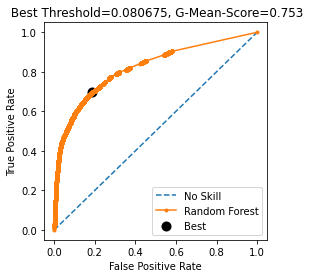

 Best Threshold=0.080675, G-Mean-Score=0.753
{'Threshold': 0.08067460317460318, 'TP': 1725, 'FP': 8924, 'TN': 38602, 'FN': 749, 'accuracy': 0.80654, 'precision': 0.16198704103671707, 'recall': 0.6972514147130153, 'specificity': 0.8122290956529058, 'F1 score': 0.26289720338337275, 'F2 score': 0.4198101727914334, 'GMeans': 0.7525475971757943, 'roc_auc_score': 0.820087973120172}


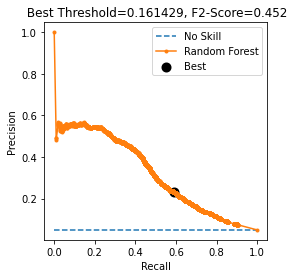

 Best Threshold=0.161429, F2-Score=0.452
{'Threshold': 0.16142857142857142, 'TP': 1461, 'FP': 4831, 'TN': 42695, 'FN': 1013, 'accuracy': 0.88312, 'precision': 0.23219961856325494, 'recall': 0.5905416329830234, 'specificity': 0.8983503766359466, 'F1 score': 0.3333333333333333, 'F2 score': 0.45126019273535944, 'GMeans': 0.7283634384079873, 'roc_auc_score': 0.820087973120172}


In [ ]:
def RF(X_train, Y_train, X_test, Y_test, class_weight=None, verbose = True):
    rf = RandomForestClassifier(random_state=1, class_weight=class_weight)
    rf.fit(X_train,Y_train)
    Y_pred = rf.predict(X_test)
    Y_pred_prob = rf.predict_proba(X_test)[:,1]
    if verbose:
        out1 = plot_roc_curve(Y_test, Y_pred_prob, label = 'Random Forest')
        out2 = plot_pr_curve(Y_test, Y_pred_prob, label = 'Random Forest', score_type='F2')      
    return out1, out2

rf_out1, rf_out2 = RF(X_train, Y_train, X_test, Y_test, class_weight=class_weight) 

### XGBoost

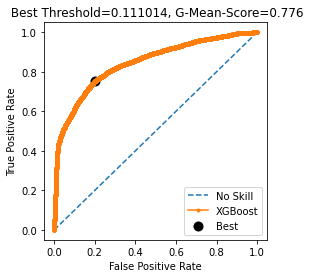

 Best Threshold=0.111014, G-Mean-Score=0.776
{'Threshold': 0.11101418, 'TP': 1860, 'FP': 9443, 'TN': 38083, 'FN': 614, 'accuracy': 0.79886, 'precision': 0.16455808192515262, 'recall': 0.751818916734034, 'specificity': 0.8013087573117872, 'F1 score': 0.2700152427959643, 'F2 score': 0.43869993867635265, 'GMeans': 0.7761694930178864, 'roc_auc_score': 0.8461397473249634}


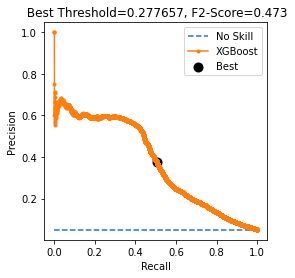

 Best Threshold=0.277657, F2-Score=0.473
{'Threshold': 0.27765658, 'TP': 1254, 'FP': 2103, 'TN': 45423, 'FN': 1220, 'accuracy': 0.93354, 'precision': 0.3735478105451296, 'recall': 0.5068714632174616, 'specificity': 0.9557505365484156, 'F1 score': 0.4301149031040988, 'F2 score': 0.4731004300913, 'GMeans': 0.696019161324722, 'roc_auc_score': 0.8461397473249634}


In [ ]:
def XGB(X_train, Y_train, X_test, Y_test, class_weight=None, verbose = True):
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, scale_pos_weight=class_weight[1]/class_weight[0] )
    xgb_model.fit(X_train, Y_train) 
    Y_pred = xgb_model.predict(X_test)
    Y_pred_prob = xgb_model.predict_proba(X_test)[:,1]
    if verbose:
        out1 = plot_roc_curve(Y_test, Y_pred_prob, label = 'XGBoost')
        out2 = plot_pr_curve(Y_test, Y_pred_prob, label = 'XGBoost', score_type='F2')      
    return out1, out2

xgb_out1, xgb_out2 = XGB(X_train, Y_train, X_test, Y_test, class_weight=class_weight)

### Neural Networks

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


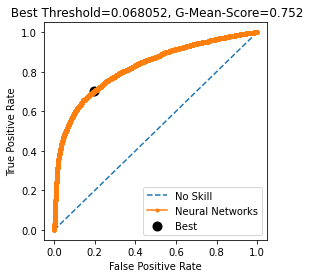

 Best Threshold=0.068052, G-Mean-Score=0.752
{'Threshold': 0.06805241, 'TP': 1736, 'FP': 9270, 'TN': 38256, 'FN': 738, 'accuracy': 0.79984, 'precision': 0.1577321461021261, 'recall': 0.7016976556184317, 'specificity': 0.8049488700921601, 'F1 score': 0.257566765578635, 'F2 score': 0.4152712659075687, 'GMeans': 0.7515522171056208, 'roc_auc_score': 0.8244697639186971}


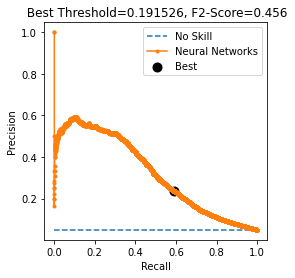

 Best Threshold=0.191526, F2-Score=0.456
{'Threshold': 0.1915259, 'TP': 1464, 'FP': 4699, 'TN': 42827, 'FN': 1010, 'accuracy': 0.88582, 'precision': 0.23754664935907838, 'recall': 0.5917542441390461, 'specificity': 0.9011278037284854, 'F1 score': 0.33900659951372003, 'F2 score': 0.45581916682234264, 'GMeans': 0.7302370864096321, 'roc_auc_score': 0.8244697639186971}


In [ ]:
def NN(X_train, Y_train, X_test, Y_test, class_weight=None, verbose = True, learningR= 1e-2, epochs= 40, batch_size=256, plot =False):
    model = Sequential()
    model.add(Dense(256,activation='relu',input_dim= X_train.shape[1]))
    #model.add(Dense(128,activation='relu') )
    #model.add( Dropout(0.3))
    #model.add( BatchNormalization())
    model.add(Dense(32,activation='relu') )
    #model.add( Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))

    mtrcs = [
    #    FalseNegatives(name="fn"),
    #    FalsePositives(name="fp"),
    #    TrueNegatives(name="tn"),
    #    TruePositives(name="tp"),
    #    Precision(name="precision"),
        Recall(name="recall"),
    #    'accuracy', 
        F1Score(num_classes=1, threshold=0.5)
    ]

    model.compile(loss='binary_crossentropy',optimizer=Adam(learningR),metrics=mtrcs)
    history = model.fit(X_train,Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size,class_weight=class_weight, verbose = 0)
    Y_pred_prob = model.predict(X_test)
    Y_pred = [round(x[0]) for x in Y_pred_prob]
    if plot:
        # plot training history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    if verbose:
        out1 = plot_roc_curve(Y_test, Y_pred_prob, label = 'Neural Networks')
        out2 = plot_pr_curve(Y_test, Y_pred_prob, label = 'Neural Networks', score_type='F2')      
    return out1, out2

nn_out1, nn_out2 = NN(X_train, Y_train, X_test,Y_test, class_weight=class_weight)


<a name="Conclusion"></a>
# Conclusion

The following is the summary of the metrics for all models. Looking at the plots, `Logistic Regression` model seems to be an light and fast option given the fact that it relatively perfomes well (`F2` and `roc_auc_score` scores) and it is very fast. 

Obviously the more sofisticate models like `Neural Network` and `XGBoost` are performing better even without any hyperparameter tuning. It is expected that their performance improve quite a bit with hyperparameter tuning.

One other aspect is changing imputating, encoding and resampling functions to improve results. Based on few trials that I did, imputation did not have huge influence but encoding (`discipline_id` for example) and resampling had bigger impact on the scores. There is certainly place for more investigations on encoding/resampling.

The other important factor is selecting/defining a good metric for our application. Here I tried to give more emphesis to `False Negatives` by using `F2` along with `roc_auc_score` scores. But there can be other customised metric as well as threshold selection process that fits better for this dataset and its specific application. 



In [ ]:
metric_df = pd.DataFrame(lr_out2, index=[0])
for dict1 in [nb_out2, sgd_out2, rf_out2, xgb_out2, nn_out2]:
    temp = pd.DataFrame( dict1, index=[0]) 
    metric_df = metric_df.append(temp)

metric_df.index = ['lr', 'nb', 'sgd', 'rf', 'xgb', 'nn']
metric_df

,Threshold,TP,FP,TN,FN,accuracy,precision,recall,specificity,F1 score,F2 score,GMeans,roc_auc_score
lr,0.351126,1381,3466,44060,1093,0.90882,0.284919,0.558205,0.927071,0.377271,0.468358,0.719372,0.832401
nb,0.220974,1286,2861,44665,1188,0.91902,0.310104,0.519806,0.939801,0.388461,0.457879,0.698938,0.792403
sgd,0.344559,1322,2939,44587,1152,0.91818,0.310256,0.534357,0.938160,0.392576,0.466907,0.708034,0.824322
rf,0.161429,1461,4831,42695,1013,0.88312,0.232200,0.590542,0.898350,0.333333,0.451260,0.728363,0.820088
xgb,0.277657,1254,2103,45423,1220,0.93354,0.373548,0.506871,0.955751,0.430115,0.473100,0.696019,0.846140
nn,0.191526,1464,4699,42827,1010,0.88582,0.237547,0.591754,0.901128,0.339007,0.455819,0.730237,0.824470


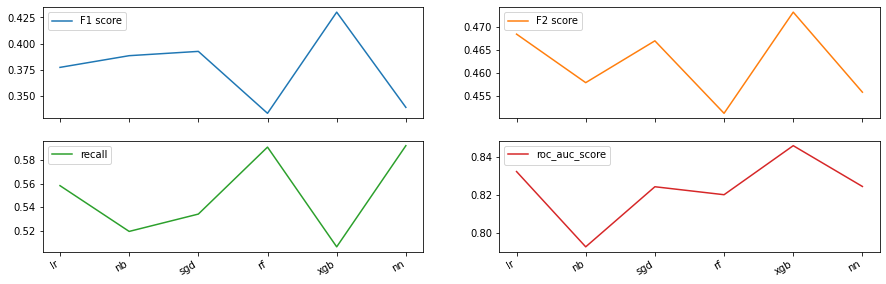

In [ ]:
metric_df[['F1 score',	'F2 score',	'recall',	'roc_auc_score']].plot( subplots= True, layout= (2,2), figsize=(15,5) );